In [1]:
# %mkdir ../data
# !wget -O ../data/aclImdb_v1.tar.gz http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
# !tar -zxf ../data/aclImdb_v1.tar.gz -C ../data

In [2]:
import os
import glob

def read_imdb_data(data_dir='../data/aclImdb'):
    data = {}
    labels = {}
    
    for data_type in ['train', 'test']:
        data[data_type] = {}
        labels[data_type] = {}
        
        for sentiment in ['pos', 'neg']:
            data[data_type][sentiment] = []
            labels[data_type][sentiment] = []
            
            path = os.path.join(data_dir, data_type, sentiment, '*.txt')
            files = glob.glob(path)
            
            for f in files:
                with open(f) as review:
                    data[data_type][sentiment].append(review.read())
                    labels[data_type][sentiment].append(1 if sentiment == 'pos' else 0)
                    
            assert len(data[data_type][sentiment]) == len(labels[data_type][sentiment]), \
                    "{}/{} data size does not match labels size".format(data_type, sentiment)
                
    return data, labels

In [3]:
data, labels = read_imdb_data()
print("IMDB reviews: train = {} pos / {} neg, test = {} pos / {} neg".format(
            len(data['train']['pos']), len(data['train']['neg']),
            len(data['test']['pos']), len(data['test']['neg'])))

IMDB reviews: train = 12500 pos / 12500 neg, test = 12500 pos / 12500 neg


In [4]:
from sklearn.utils import shuffle

def prepare_imdb_data(data, labels):
    data_train = data['train']['pos'] + data['train']['neg']
    data_test = data['test']['pos'] + data['test']['neg']
    labels_train = labels['train']['pos'] + labels['train']['neg']
    labels_test = labels['test']['pos'] + labels['test']['neg']
    
    data_train, labels_train = shuffle(data_train, labels_train)
    data_test, labels_test = shuffle(data_test, labels_test)
    
    return data_train, data_test, labels_train, labels_test

In [5]:
train_X, test_X, train_y, test_y = prepare_imdb_data(data, labels)
print("IMDb reviews (combined): train = {}, test = {}".format(len(train_X), len(test_X)))

IMDb reviews (combined): train = 25000, test = 25000


In [6]:
print(train_X[100])
print(train_y[100])

This is my favorite of the three care bears movies. Once again I liked all the songs. The big problem however as most people have pointed out was that this story contradicts the original. For those that saw the first movie recall the bears met their "cousins" who they apparently never knew about. It wasn't of course until the end that the cousins received their tummy symbols after proving how much they cared. In this story however the cousins grow up with the care bears and have tummy symbols all along. That being said this isn't a bad movie as long you keep it separate from the first. I thought the Darkheart character much more evil then the Nicholas of the first. But at the same time I felt it added a sort of balance to the sweetness of the care bears. I also liked the we care part at the end, although I know other people had mixed feelings about that scene. And of course I LOVED the songs. My favorites being Growing Up and Forever Young. The care bears movies have always had such go

In [7]:
print(len(train_X[100]))

1042


In [8]:
!pip install nltk

In [9]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *

import re
from bs4 import BeautifulSoup

def review_to_words(review):
    nltk.download("stopwords", quiet=True)
    stemmer = PorterStemmer()
    
    text = BeautifulSoup(review, "html.parser").get_text() 
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower()) 
    words = text.split() 
    words = [w for w in words if w not in stopwords.words("english")] 
    words = [PorterStemmer().stem(w) for w in words]
    
    return words

In [10]:
review_to_words(train_X[100])

['favorit',
 'three',
 'care',
 'bear',
 'movi',
 'like',
 'song',
 'big',
 'problem',
 'howev',
 'peopl',
 'point',
 'stori',
 'contradict',
 'origin',
 'saw',
 'first',
 'movi',
 'recal',
 'bear',
 'met',
 'cousin',
 'appar',
 'never',
 'knew',
 'cours',
 'end',
 'cousin',
 'receiv',
 'tummi',
 'symbol',
 'prove',
 'much',
 'care',
 'stori',
 'howev',
 'cousin',
 'grow',
 'care',
 'bear',
 'tummi',
 'symbol',
 'along',
 'said',
 'bad',
 'movi',
 'long',
 'keep',
 'separ',
 'first',
 'thought',
 'darkheart',
 'charact',
 'much',
 'evil',
 'nichola',
 'first',
 'time',
 'felt',
 'ad',
 'sort',
 'balanc',
 'sweet',
 'care',
 'bear',
 'also',
 'like',
 'care',
 'part',
 'end',
 'although',
 'know',
 'peopl',
 'mix',
 'feel',
 'scene',
 'cours',
 'love',
 'song',
 'favorit',
 'grow',
 'forev',
 'young',
 'care',
 'bear',
 'movi',
 'alway',
 'good',
 'song',
 'ten',
 'star',
 'good',
 'movi']

In [11]:
import pickle

cache_dir = os.path.join("../cache", "sentiment_analysis")  
os.makedirs(cache_dir, exist_ok=True) 
def preprocess_data(data_train, data_test, labels_train, labels_test,
                    cache_dir=cache_dir, cache_file="preprocessed_data.pkl"):

    cache_data = None
    if cache_file is not None:
        try:
            with open(os.path.join(cache_dir, cache_file), "rb") as f:
                cache_data = pickle.load(f)
            print("Read preprocessed data from cache file:", cache_file)
        except:
            pass 
    
    if cache_data is None:
        words_train = [review_to_words(review) for review in data_train]
        words_test = [review_to_words(review) for review in data_test]
        
        if cache_file is not None:
            cache_data = dict(words_train=words_train, words_test=words_test,
                              labels_train=labels_train, labels_test=labels_test)
            with open(os.path.join(cache_dir, cache_file), "wb") as f:
                pickle.dump(cache_data, f)
            print("Wrote preprocessed data to cache file:", cache_file)
    else:
        words_train, words_test, labels_train, labels_test = (cache_data['words_train'],
                cache_data['words_test'], cache_data['labels_train'], cache_data['labels_test'])
    
    return words_train, words_test, labels_train, labels_test

In [12]:


train_X, test_X, train_y, test_y = preprocess_data(train_X, test_X, train_y, test_y)

Read preprocessed data from cache file: preprocessed_data.pkl


In [13]:
len(test_X)

25000

In [14]:
import numpy as np

def build_dict(data, vocab_size = 5000):
    word_count = {} 
    
    for item in data:
        for word in item:
            if word not in word_count:
                word_count[word] = 1
            else:
                word_count[word] +=1

    sorted_words = sorted(word_count, key=word_count.get, reverse=True)
    
    word_dict = {} 
    for idx, word in enumerate(sorted_words[:vocab_size - 2]): 
        word_dict[word] = idx + 2                             
        
    return word_dict

In [15]:
word_dict = build_dict(train_X)

In [17]:
data_dir = '../data/pytorch'
if not os.path.exists(data_dir): 
    os.makedirs(data_dir)

In [18]:
with open(os.path.join(data_dir, 'word_dict.pkl'), "wb") as f:
    pickle.dump(word_dict, f)

In [19]:
def convert_and_pad(word_dict, sentence, pad=500):
    NOWORD = 0 
    INFREQ = 1 
    working_sentence = [NOWORD] * pad
    for word_index, word in enumerate(sentence[:pad]):
        if word in word_dict:
            working_sentence[word_index] = word_dict[word]
        else:
            working_sentence[word_index] = INFREQ
            
    return working_sentence, min(len(sentence), pad)
def convert_and_pad_data(word_dict, data, pad=500):
    result = []
    lengths = []
    
    for sentence in data:
        converted, leng = convert_and_pad(word_dict, sentence, pad)
        result.append(converted)
        lengths.append(leng)
        
    return np.array(result), np.array(lengths)

In [20]:
train_X, train_X_len = convert_and_pad_data(word_dict, train_X)
test_X, test_X_len = convert_and_pad_data(word_dict, test_X)

In [21]:
len(train_X)

25000

In [22]:
print(train_X[100])
print(train_X_len[100])

[ 591  573   46   23  512 1016 2043 1573 2681  174    2  562   21 4967
   90    3  311   11   79  132 1422   47    2  172 2251   12 2310 1573
 2681    2   59 1573 2681    2  311  184  113  685  822  728    3 1016
 2043 3204 1386 1310   30   59 1573 2681  371    3 1239  793   33   17
    1 1205  404 2956 2681    2  178    5    4    3   14  848 3185    1
 1994    1  871 2043  177   43   36  129 2750 1442    1  265    3   57
   98   28  145  881  416  523 1573 2681 4641  331  822   28 2681 2681
 1455  167  822   87  366  228 2681   37  139   93  256    2   47   28
    3  197   76 4781 2886  220   37  822  517  129 1292   42    3  368
  509   33 1534   93  169    3  704 1121    1 1633  890   13  117 2681
  459  193  881  249  416   90   28  648  144  179 3671  958  108    1
   22    2  573 3642   45   64  606   61  887   92   39 1101 2043 1311
    1  881   23  149  521 3281  571   22   28 1016 2043   22   14 1849
 3281  146  584 2714  909 1016 2043    1    1    8  196  495  152 1719
    4 

In [23]:
import pandas as pd
    
pd.concat([pd.DataFrame(train_y), pd.DataFrame(train_X_len), pd.DataFrame(train_X)], axis=1) \
        .to_csv(os.path.join(data_dir, 'train.csv'), header=False, index=False)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [24]:
import sagemaker

sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = 'sagemaker/sentiment_rnn'

role = sagemaker.get_execution_role()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [25]:
input_data = sagemaker_session.upload_data(path=data_dir, bucket=bucket, key_prefix=prefix)

In [26]:
!pygmentize train/model.py

import torch.nn as nn

class LSTMClassifier(nn.Module):
  

    def __init__(self, embedding_dim, hidden_dim, vocab_size):
        
        super(LSTMClassifier, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        self.dense = nn.Linear(in_features=hidden_dim, out_features=1)
        self.sig = nn.Sigmoid()
        
        self.word_dict = None

    def forward(self, x):
        
        x = x.t()
        lengths = x[0,:]
        reviews = x[1:,:]
        embeds = self.embedding(reviews)
        lstm_out, _ = self.lstm(embeds)
        out = self.dense(lstm_out)
        out = out[lengths - 1, range(len(lengths))]
        return self.sig(out.squeeze())


In [27]:
!pip install torchvision 


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 64.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 62.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 27.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 830.0 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 4.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 9.1 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 3.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 1.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.8/209.8 MB 1.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 41.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━

In [28]:
import torch
import torch.utils.data

train_sample = pd.read_csv(os.path.join(data_dir, 'train.csv'), header=None, names=None, nrows=250)

train_sample_y = torch.from_numpy(train_sample[[0]].values).float().squeeze()
train_sample_X = torch.from_numpy(train_sample.drop([0], axis=1).values).long()

train_sample_ds = torch.utils.data.TensorDataset(train_sample_X, train_sample_y)
train_sample_dl = torch.utils.data.DataLoader(train_sample_ds, batch_size=50)

In [29]:
def train(model, train_loader, epochs, optimizer, loss_fn, device):
    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0
        for batch in train_loader:         
            batch_X, batch_y = batch
            
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)
            
            optimizer.zero_grad()
            out = model.forward(batch_X)
            loss = loss_fn(out, batch_y)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.data.item()
        print("Epoch: {}, BCELoss: {}".format(epoch, total_loss / len(train_loader)))

In [30]:
import torch.optim as optim
from train.model import LSTMClassifier

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = LSTMClassifier(32, 100, 5000).to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.BCELoss()

train(model, train_sample_dl, 5, optimizer, loss_fn, device)

cpu
Epoch: 1, BCELoss: 0.6961587548255921
Epoch: 2, BCELoss: 0.6857810974121094
Epoch: 3, BCELoss: 0.6769315242767334
Epoch: 4, BCELoss: 0.6673193216323853
Epoch: 5, BCELoss: 0.6558300375938415


In [31]:
from sagemaker.pytorch import PyTorch

estimator = PyTorch(entry_point="train.py",
                    source_dir="train",
                    role=role,
                    framework_version='1.8.1', 
                    py_version="py3",   
                    train_instance_count=1,
                    train_instance_type='ml.m4.xlarge', 
                    hyperparameters={
                        'epochs': 20,
                        'hidden_dim': 200,
                    })

estimator.fit({'training': input_data})

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2023-12-13-18-21-37-175


Using provided s3_resource
2023-12-13 18:21:37 Starting - Starting the training job...
2023-12-13 18:22:02 Starting - Preparing the instances for training............
2023-12-13 18:23:59 Downloading - Downloading input data...
2023-12-13 18:24:34 Downloading - Downloading the training image......
2023-12-13 18:25:30 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-12-13 18:25:37,548 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-12-13 18:25:37,551 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-12-13 18:25:37,562 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-12-13 18:25:37,565 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-12-13 18:25:37,769 sagemaker-training-toolkit INFO     Instal

In [32]:
!pip install matplotlib

INFO:matplotlib.font_manager:generated new fontManager


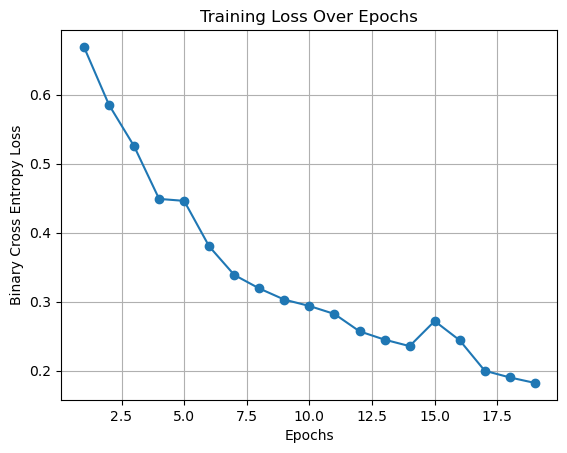

In [33]:
import matplotlib.pyplot as plt

epochs = list(range(1, 20))
loss_values = [
    0.6690408940217933, 0.5850774889089623, 0.5253639409736711, 0.448875014271055,
    0.4460091006999113, 0.38000536208250085, 0.33870953078172644, 0.3191174469432052,
    0.30293984133370067, 0.2937456564027436, 0.2821461080896611, 0.25704940971063106,
    0.2449793216525292, 0.23558637864735663, 0.271874051313011, 0.24400102818498806,
    0.19991839449016416, 0.1902288554274306, 0.18227853793270735
]

plt.plot(epochs, loss_values, marker='o')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Binary Cross Entropy Loss')
plt.grid(True)
plt.show()


In [34]:
# TODO: Deploy the trained model
estimator_predictor = estimator.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

INFO:sagemaker:Repacking model artifact (s3://sagemaker-us-east-1-541448256856/pytorch-training-2023-12-13-18-21-37-175/output/model.tar.gz), script artifact (s3://sagemaker-us-east-1-541448256856/pytorch-training-2023-12-13-18-21-37-175/source/sourcedir.tar.gz), and dependencies ([]) into single tar.gz file located at s3://sagemaker-us-east-1-541448256856/pytorch-training-2023-12-13-22-35-46-064/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: pytorch-training-2023-12-13-22-35-46-064
INFO:sagemaker:Creating endpoint-config with name pytorch-training-2023-12-13-22-35-46-064
INFO:sagemaker:Creating endpoint with name pytorch-training-2023-12-13-22-35-46-064


-------!

In [35]:
test_X = pd.concat([pd.DataFrame(test_X_len), pd.DataFrame(test_X)], axis=1)

In [36]:
def predict(data, rows=512):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = np.array([])
    for array in split_array:
        predictions = np.append(predictions, estimator_predictor.predict(array))
    
    return predictions

In [37]:
predictions = predict(test_X.values)
predictions = [round(num) for num in predictions]

In [38]:
from sklearn.metrics import accuracy_score
accuracy_score(test_y, predictions)

0.8496

In [39]:
test_review = 'The simplest pleasures in life are the best, and this film is one of them. Combining a rather basic storyline of love and adventure this movie transcends the usual weekend fair with wit and unmitigated charm.'

In [40]:
test_review_X, test_review_len = convert_and_pad(word_dict, review_to_words(test_review))

In [41]:
test_data = np.hstack((test_review_len, test_review_X))
test_data = test_data.reshape(1, -1)

In [42]:
test_data.shape

(1, 501)

In [43]:
estimator_predictor.predict(test_data)

array(0.98979938)

In [44]:
estimator.delete_endpoint()

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [45]:
!pygmentize serve/predict.py

# import argparse
# import json
# import os
# import pickle
# import sys
# import pandas as pd
# import numpy as np
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import torch.utils.data

# from model import LSTMClassifier

# from utils import review_to_words, convert_and_pad

# def model_fn(model_dir):
#     """Load the PyTorch model from the `model_dir` directory."""
#     print("Loading model.")

#     # First, load the parameters used to create the model.
#     model_info = {}
#     model_info_path = os.path.join(model_dir, 'model_info.pth')
#     with open(model_info_path, 'rb') as f:
#         model_info = torch.load(f)

#     print("model_info: {}".format(model_info))

#     # Determine the device and construct the model.
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     model = LSTMClassifier(model_info['embedding_dim'], model_info['hidden_dim'], model_info['vocab_size'])

#     # Load the store model parameters.
#     mod

In [47]:
from sagemaker.predictor import RealTimePredictor
from sagemaker.pytorch import PyTorchModel

class StringPredictor(RealTimePredictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(StringPredictor, self).__init__(endpoint_name, sagemaker_session, content_type='text/plain')

model = PyTorchModel(model_data=estimator.model_data,
                     role = role,
                     framework_version='1.8.1',
                     py_version="py3",   
                     entry_point='predict.py',
                     source_dir='serve',
                     predictor_cls=StringPredictor)
predictor = model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


INFO:sagemaker:Repacking model artifact (s3://sagemaker-us-east-1-541448256856/pytorch-training-2023-12-13-18-21-37-175/output/model.tar.gz), script artifact (serve), and dependencies ([]) into single tar.gz file located at s3://sagemaker-us-east-1-541448256856/pytorch-inference-2023-12-13-22-46-42-576/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: pytorch-inference-2023-12-13-22-46-43-512
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2023-12-13-22-46-44-172
INFO:sagemaker:Creating endpoint with name pytorch-inference-2023-12-13-22-46-44-172


-------!

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [48]:
def test_reviews(predictor, data_dir='../data/aclImdb', stop=250):
    results = []
    ground = []

    for sentiment in ['pos', 'neg']:
        path = os.path.join(data_dir, 'test', sentiment, '*.txt')
        files = glob.glob(path)

        files_read = 0

        print('Starting ', sentiment, ' files')

        for f in files:
            with open(f) as review:
                if sentiment == 'pos':
                    ground.append(1)
                else:
                    ground.append(0)
                review_input = review.read().encode('utf-8')
                results.append(float(predictor.predict(review_input)))

            files_read += 1
            if files_read == stop:
                break

    return ground, results


In [49]:
accept_header = 'text/plain'  # Specify the expected response content type
endpoint_name = 'pytorch-inference-2023-12-13-22-46-44-172'  # Replace with your actual endpoint name
predictor = sagemaker.predictor.RealTimePredictor(endpoint_name=endpoint_name, content_type=accept_header)

ground, results = test_reviews(predictor)


See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
Starting  pos  files
Starting  neg  files


In [50]:
from sklearn.metrics import accuracy_score
accuracy_score(ground, results)

0.85

In [52]:
from sklearn.metrics import classification_report
print(classification_report(ground, results))

              precision    recall  f1-score   support

           0       0.92      0.77      0.84       250
           1       0.80      0.93      0.86       250

    accuracy                           0.85       500
   macro avg       0.86      0.85      0.85       500
weighted avg       0.86      0.85      0.85       500



In [53]:
predictor.predict(test_review)

b'1.0'

In [54]:
predictor.endpoint

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


'pytorch-inference-2023-12-13-22-46-44-172'

In [56]:
# predictor.delete_endpoint()